# Reverse SuCOS scoring method

1. Break designed compound into bits at rotable bonds
2. SuCOS score these individual bits to all the fragments - a high sucCOS score would indicate that the shape/chem feature of the bit is best captured by that fragment
3. Capture best matching fragment IDs and bits
4. Score using Score_1, Score_2 and Score_3 as described in the README
5. All fragment matches captured in sdf file
6. Top fragment matches with reverse SuCOS scores of > 0.50 also captured in sdf file

In [33]:
from rdkit.Chem.Lipinski import RotatableBondSmarts
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit import RDConfig
import os
import numpy as np
import pandas as pd
from datetime import datetime

date = datetime.today().strftime('%Y-%m-%d')

def getBits(mol):
    '''

    Parameters
    ----------
    mol : rdkit mol object to be broken up into fragments by breaking 
    rotable bonds

    Returns
    -------
    mols : A list of rdkit mol objects

    '''
    # Try break everything up - aromatics and aliphatics into single bits!
    smart_breaks = Chem.MolFromSmarts('[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]')
    
    bis = mol.GetSubstructMatches(smart_breaks)
    
    bs = [mol.GetBondBetweenAtoms(x,y).GetIdx()for x,y in bis]
    
    nm = Chem.FragmentOnBonds(mol,bs)
    
    bit_smiles = Chem.MolToSmiles(nm,True)
    
    # Get individual bits
    mols = [Chem.MolFromSmiles(smi) for smi in bit_smiles.split('.')]
    
    
    
#     # find the rotatable bonds
#     bonds = mol.GetSubstructMatches(smart_breaks)
# #     # find the rotatable bonds
# #     bonds = mol.GetSubstructMatches(RotatableBondSmarts)
    
#     bonds = [((x,y),(0,0)) for x,y in bonds]
#     p = BRICS.BreakBRICSBonds(mol,bonds=bonds)
 
#     mols = [mol for mol in Chem.GetMolFrags(p,asMols=True)]
    
    return mols

# Function to build feature maps and score two mol objects
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def getFeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    try: 
        featLists = []
        for m in [small_m, large_m]:
            rawFeats = fdef.GetFeaturesForMol(m)
            # filter that list down to only include the ones we're intereted in
            featLists.append([f for f in rawFeats if f.GetFamily() in keep])
        fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
        fms[0].scoreMode = score_mode
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score
    except ZeroDivisionError:
        return 0

def getNumberfeats(mol):
    
    featLists = []
    rawFeats = fdef.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're intereted in
    featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    
    return len(featLists)

from sklearn.neighbors import NearestNeighbors

# We need to start by building a FeatureFactory object which defines 
# the set of pharmacophore features being used. 
# We'll use this to find features on the molecules.
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 
                                                'BaseFeatures.fdef'))


# Set default paramters for selecting points in feature map
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

# List of feature families that we want to use
keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


def getFeatureMap(mol_list):
    allFeats = []
    for m in mol_list:
        
        rawFeats = fdef.GetFeaturesForMol(m)
        featDeats = [(f.GetType(),
                      f.GetPos().x,
                      f.GetPos().y,
                      f.GetPos().z) for f in rawFeats if f.GetFamily() in keep]
        
        allFeats.append(featDeats)
        

    feature_map_df = pd.DataFrame([t for lst in allFeats for t in lst],
                                  columns =['featType', 'x', 'y', 'z']) 
   
    return feature_map_df


def getFeatureAgg(feature_map_df, rad_thresh):
    
    # Group data into unique feature types
    grouped_df = feature_map_df.groupby('featType')
    
    data_to_add = []
    
    for group_name, df_group in grouped_df:
        
        # Reset index df
        df_group = df_group.reset_index()

        if len(df_group) == 1:
            
            data_to_add.append(df_group)
        
        if len(df_group) > 1:
                
            # Get feature name
            feat_name = df_group.featType.unique()[0]

            # Use radius neighbours to find features within 
            # spere with radius thresh
            neigh = NearestNeighbors(radius=rad_thresh)
            
            while len(df_group) > 0:
                
                neigh.fit(df_group[['x','y','z']])
            
                # Get distances and indices of neigbours within radius threshold
                rng = neigh.radius_neighbors()
                neigh_dist = rng[0][0]
                neigh_indices = rng[1][0]
                
                # Append the first index - NB clustering done relative to index 0
                neigh_indices = list(np.append(0, neigh_indices))
                
                # Calculate average x,y,z coords for features in similar loc
                x_avg = np.mean(df_group.iloc[neigh_indices].x)
                y_avg = np.mean(df_group.iloc[neigh_indices].y)
                z_avg = np.mean(df_group.iloc[neigh_indices].z)
                
                # Add feature with average x, y and z values
                new_row = [(feat_name, x_avg, y_avg, z_avg)]
                
                cluster_df = pd.DataFrame(data=new_row, columns = ['featType', 'x', 'y', 'z'])
                
                data_to_add.append(cluster_df)
                
                # Remove indices of clustered neigbours
                df_group = df_group.drop(df_group.index[neigh_indices])
        
    # Create single DF from list of dfs
    clustered_df = pd.concat(data_to_add)

    return clustered_df


def getSDFprops(compound_mol):
    # Need to change for diff sdf files!!!
    
    # Make smiles = original SMILES 
    compound_mol.SetProp('original SMILES', compound_mol.GetProp('smiles'))
    
    # Assign ref pdb
    compound_mol.SetProp('ref_pdb', 'Fragmenstein.pdb')
    
    # Get all the sdf properties
    all_properties = list(compound_mol.GetPropsAsDict().keys())

    # Properties to keep 
    keep_properties = ['ref_pdb', 'ref_mols', 'original SMILES'] 

    # Properties to delete
    del_properties = [prop for prop in all_properties if prop not in keep_properties]

    for prop in del_properties:
            compound_mol.ClearProp(prop)

    return compound_mol


def getBlankMol(blank_mol, COS_threshold, rad_threshold):
    
    # Add compulsory props
    blank_mol.SetProp('_Name', 'ver_1.2')
    blank_mol.SetProp('ref_mols', 'Fragments that bits overlap with above a score threshold of {}.'.format(COS_threshold))
    blank_mol.SetProp('ref_url', 'https://github.com/Waztom/xchem-xCOS')
    blank_mol.SetProp('submitter_name', 'WT')
    blank_mol.SetProp('submitter_email', 'warren.thompson@diamond.ac.uk')
    blank_mol.SetProp('submitter_institution', 'Diamond Light Source')
    blank_mol.SetProp('generation_date', date)
    blank_mol.SetProp('method', 'xCOS')

    # Add scoring descriptors
    blank_mol.SetProp('N_hits', 'The number of fragments that bits overlap with above a score threshold of {}.'.format(COS_threshold))
    blank_mol.SetProp('Score_1', 'The score is scaled by the number of bit atoms')    
    blank_mol.SetProp('Score_2', 'The score is scaled by the number of bit atoms penalised by the fraction of feats matched the to total number feats clustered within a {} angstrom threshold'.format(rad_threshold))    
    blank_mol.SetProp('Score_3', 'The score is determined by the fraction of matching features to the clustered features within a {} angstrom threshold.'.format(rad_threshold))
    blank_mol.SetProp('Score_4', 'The total score is scaled by total number of bit atoms')

    return blank_mol


In [34]:
Chem.MolToSmarts(RotatableBondSmarts)

'[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]'

In [35]:
# Let's have a look at KEN compound 
ken = Chem.SDMolSupplier('in_data/KEN-MCD-4729dc98-1.sdf')

In [36]:
ken_bits = getBits(ken[0])

ValueError: too many values to unpack (expected 2)

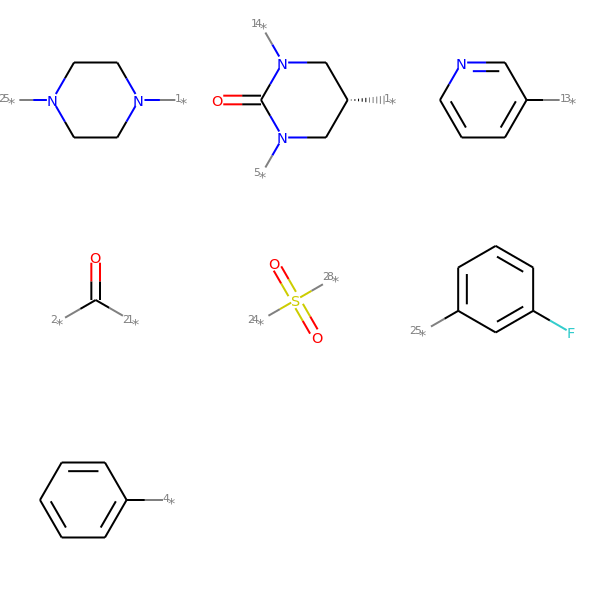

In [28]:
Draw.MolsToGridImage(ken_bits, molsPerRow=3)

In [ ]:
# See about finding aliphatic/aromatic heterocycles
for bit in ken_bits:
    
    print(Chem.rdMolDescriptors.CalcNumAliphaticHeterocycles(bit))

In [10]:
# Read in fragment mols
frag_mol_folder = 'in_data/fragment_mols'
path  = frag_mol_folder + '/'
frag_mol_list = [Chem.MolFromMolFile((path + mol_file), sanitize=True) for mol_file in os.listdir(frag_mol_folder)]

In [ ]:
# Can we find obvious fragment matches before breaking into bits? Problem with breaking into bits is highlighted
# Bit[1] (Pyrimidine ring) not foind to overlay well with Frag X0434. 
# Let's try looking for  partial to complete fragment matches with the compound
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
mol2 = ken[0]
mol_changes = []
for mol in frag_mol_list:
    try:
        print(mol.GetProp('_Name'), str(AllChem.GetBestRMS(mol, mol2)))
        patt = mol
        #print(mol2.HasSubstructMatch(patt))
        print(Chem.MolToSmiles(mol))
        mol2 = AllChem.DeleteSubstructs(patt,mol2)
        print(Chem.MolToSmiles(mol2))
        #mol_changes.append(mol_2)   
    except:
        continue



In [ ]:
# Draw mol changes
Draw.MolsToGridImage(mol_changes, molsPerRow=3)

In [ ]:
# try remove matching ligs and keep whatever is left as bits for conversion
test = AllChem.DeleteSubstructs(ken[0],mol_changes[0])
Draw.MolsToGridImage([ken[0], mol_changes[0],test], molsPerRow=3)

In [ ]:
test_bits = getBits(mol_changes[1])

In [ ]:
test_2 = AllChem.DeleteSubstructs(mol_changes[1],test)
Draw.MolsToGridImage([ken[0], mol_changes[1],test_2], molsPerRow=3)

In [ ]:
smi_bits = Chem.MolToSmiles(test_2)
smi_bits = smi_bits.split('.')  
for smi_bit in smi_bits:
    mol = Chem.MolFromSmiles(smi_bit)
    print(Chem.MolToSmiles(mol))

In [11]:
# Let's score docked bits to fragment mols
all_scores = []
for bit in ken_bits:
    scores = []
    for frag_mol in frag_mol_list:
            # NB reverse SuCOS scoring
            fm_score = getFeatureMapScore(bit, frag_mol)
            fm_score = np.clip(fm_score, 0, 1)             
            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(bit, frag_mol,
                                                             allowReordering=False)
            protrude_dist = np.clip(protrude_dist, 0, 1)
            reverse_SuCOS_score = 0.45*fm_score + 0.55*(1 - protrude_dist)
            
            # Get some info and append to list
            frag_name = frag_mol.GetProp('_Name')
            
            scores.append((frag_name, reverse_SuCOS_score))
    all_scores.append(scores)

ValueError: Bad Conformer Id

In [ ]:
len(all_scores)

In [ ]:
# Let's stay with bit 1 and see if we can do some filtering
# Cool so we have some scores! Can we filter these scores to yield fragemnt 
# with highest matching score and/or fragments with same score?
bit_1_scores = all_scores[6]
bit_1_df = pd.DataFrame(data=bit_1_scores, columns = ['Fragment','Score'])
bit_1_df[bit_1_df.Score==bit_1_df.Score.max()]

In [ ]:
# Use if we want to load docking sdf file
compound_mols = Chem.SDMolSupplier('in_data/Fragmenstein_permissive_rescored_20200609.sdf')

In [ ]:
# Get the feature map df with coordinates and feature info
feature_map_df =  getFeatureMap(frag_mol_list)

# Set radius threshold 
rad_thresh = 1.5

# Aggregate features using nearest neigbours algo
clustered_df = getFeatureAgg(feature_map_df,
                             rad_thresh=rad_thresh)

# Get number of clustered feats
no_clustered_feats = len(clustered_df)
print('{} clustered features found with radius threshold {}'.format(no_clustered_feats, rad_thresh))

In [ ]:
def getReverseScores(clustered_df, compound_mols, rad_threshold, 
                     COS_threshold, filename):
    
    # Get writer set up for writing final mols to file
    w = Chem.SDWriter(filename)
    
    # Sort out blank mole
    blank_mol = compound_mols[0]
    
    # Keep sdf props we want
    blank_mol = getSDFprops(blank_mol)

    # Assign required props for ver 1.2 spec
    blank_mol = getBlankMol(blank_mol, COS_threshold, rad_threshold)

    # Write to file
    w.write(blank_mol)
    
    # Score eveything besides for first mol
    for i in range(len(compound_mols)):
        
        index = i + 1
        
        if index > len(compound_mols):
            break
        
        else:
        
            # Get compound mol
            compound_mol = compound_mols[index]
            
            # Get the bits
            compound_bits = getBits(compound_mol)

            # We are going to include a feature mapping score, where the 
            # number of features of the compound matching the clustered feats 
            # within a threshold are found

            # Get feature map of compound bits as df
            feature_map_bits = getFeatureMap(compound_bits)

            # Group data into unique feature types
            grouped_df = feature_map_bits.groupby('featType')

            no_feats_matched = []
            dist_feats_matched = []

            # Use radius neighbours to find features within 
            # sphere with radius thresh
            neigh = NearestNeighbors(radius=rad_threshold)

            # Loop through grouped features
            for group_name, df_group in grouped_df:          

                # Get feat name
                feat_name = df_group.featType.unique()[0]

                # Get simmilar feats from cluster df
                cluster_test = clustered_df[clustered_df.featType==feat_name]

                # Reset index df
                df_group = df_group.reset_index()

                if len(cluster_test) == 1:

                    # Calculate distances
                    x1_sub_x2 = (cluster_test.iloc[0].x - df_group.iloc[0].x)**2
                    y1_sub_y2 = (cluster_test.iloc[0].y - df_group.iloc[0].y)**2
                    z1_sub_z2 = (cluster_test.iloc[0].z - df_group.iloc[0].z)**2

                    diff_sum = x1_sub_x2 + y1_sub_y2 + z1_sub_z2

                    dist = diff_sum**0.5

                    if dist < rad_threshold:

                        # Let's get the number of feats matched
                        no_feats_matched.append(1)

                        # Let's get the distance of the feats matched
                        dist_feats_matched.append([dist])                

                if len(cluster_test) > 1:
                    neigh.fit(cluster_test[['x','y','z']])

                    while len(df_group) > 0:

                        # Get distances and indices of neigbours within radius threshold
                        feat_coords = [[df_group.iloc[0].x, df_group.iloc[0].y, df_group.iloc[0].z]]
                        rng = neigh.radius_neighbors(feat_coords)

                        neigh_dist = rng[0][0]
                        neigh_indices = rng[1][0]

                        # Let's get the number of feats matched
                        no_feats_matched.append(len(neigh_indices))

                        # Remove index 0 of df_group
                        df_group = df_group.drop(df_group.index[0])

            # Get total number of feat matches 
            no_feats = np.sum(no_feats_matched)

            all_scores = []

            for bit in compound_bits:

                # Get number of bit atoms
                no_bit_atoms = bit.GetNumAtoms()

                scores = []
                for frag_mol in frag_mol_list:

                        # NB reverse SuCOS scoring
                        fm_score = getFeatureMapScore(bit, frag_mol)
                        fm_score = np.clip(fm_score, 0, 1)             
                        protrude_dist = rdShapeHelpers.ShapeProtrudeDist(bit, frag_mol,
                                                                         allowReordering=False)
                        protrude_dist = np.clip(protrude_dist, 0, 1)

                        reverse_SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)

                        # Get number of feats from bit for scaling score
                        no_bit_feats = getNumberfeats(bit)

                        # Get some info and append to list
                        frag_name = frag_mol.GetProp('_Name').strip('Mpro-')

                        scores.append((frag_name, reverse_SuCOS_score, no_bit_atoms, no_bit_feats))

                all_scores.append(scores)

                list_dfs = [] 
                for score in all_scores:
                    df = pd.DataFrame(data=score, columns = ['Fragment','Score','No_bit_atoms', 'No_bit_feats'])
                    # Get maximum scoring fragment for bit match
                    df = df[df['Score'] == df['Score'].max()]
                    list_dfs.append(df)

                final_df = pd.concat(list_dfs)

                # Get total bit score and some denominator terms
                bits_score = (final_df.No_bit_atoms * final_df.Score).sum()
                total_atoms = final_df.No_bit_atoms.sum()
                feat_match_fraction = no_feats / no_clustered_feats

                # Score 1: the score is scaled by the number of bit atoms
                score_1 = bits_score

                # Score 2: the score is scaled by the number of bit atoms
                # penalised by the fraction of feats matched 
                # the to total number feats clustered
                score_2 = score_1 * feat_match_fraction

                # Score 3: the score is determined by the fraction of matching 
                # features to the clustered features within a threshold. This
                # should yield similar values to Tim's Featurestein method?
                score_3 = feat_match_fraction
                
                score_4 = final_df.Score.sum() / total_atoms

                # Let's only get frags above a threshold
                final_df = final_df[final_df.Score > COS_threshold]

                # Let#s sort the df by increasing score
                final_df = final_df.sort_values(by=['Score'], ascending=False)

                # Get the unique fragments above threshold
                all_frags = pd.unique(final_df.Fragment)

            # Set sdf props - see function for props to keep and drop            
            compound_mol = getSDFprops(compound_mol)

            # Add props we want                                   
            compound_mol.SetProp('ref_mols',','.join(all_frags))
            compound_mol.SetProp('N_hits', str(len(all_frags)))
            compound_mol.SetProp('Score_1', "{:.4f}".format(score_1))
            compound_mol.SetProp('Score_2', "{:.4f}".format(score_2))
            compound_mol.SetProp('Score_3', "{:.4f}".format(score_3))
            compound_mol.SetProp('Score_4', "{:.4f}".format(score_4))


            # Write to file
            w.write(compound_mol)

In [ ]:
# Let's do all of the compounds
getReverseScores(clustered_df=clustered_df, compound_mols=compound_mols,
                 rad_threshold=1.0, COS_threshold=0.50, 
                 filename='out_data/xCOS_Teo_{}.sdf'.format(date))